In [1]:
import matplotlib.pyplot as plt

from pyspark import SparkContext

In [2]:
mxm_data = sc.pickleFile("../data/mxm_dataset_all/")
metadata = sc.pickleFile("../data/metadata-songs/")

In [3]:
hotness_rdd = metadata.map(lambda x: (x[0], x[1]['song_hotttnesss'][0]))
hotness_rdd.first()

('TRAAAAW128F429D538', 0.60211998990575477)

In [4]:
mxm_data.count()

237662

In [5]:
hotness_rdd.count()

10000

In [6]:
def aggWordCount(localRes, newElem):
    if len(localRes) == 0:
        res = {}
        for (k, v) in newElem[1]:
            res[k] = v
        return res
    else:
        for (k, v) in newElem[1]:
            if k in localRes:
                localRes[k] += v
            else:
                localRes[k] = v
        return localRes
    
def combResults(a, b):
    if len(a) == 0:
        return b
    else:
        res = {}
        for k in a:
            res[k] = a[k]
        for k in b:
            if k in res:
                res[k] += b[k]
            else:
                res[k] = b[k]
        return res

cnts = mxm_data.map(lambda x: (x[0], x[1]["words"])).aggregate([], aggWordCount, combResults)

In [7]:
s = sorted(cnts, key=cnts.get, reverse=True)
    
for k in s:
    print(k, ": ", cnts[k])

(u'i', ': ', 2078808)
(u'the', ': ', 1863782)
(u'you', ': ', 1744257)
(u'to', ': ', 1067578)
(u'and', ': ', 1055748)
(u'a', ': ', 974499)
(u'it', ': ', 821152)
(u'me', ': ', 771755)
(u'not', ': ', 735396)
(u'in', ': ', 626410)
(u'my', ': ', 611942)
(u'is', ': ', 595735)
(u'of', ': ', 540064)
(u'that', ': ', 474535)
(u'do', ': ', 470946)
(u'your', ': ', 463681)
(u'on', ': ', 419354)
(u'am', ': ', 407827)
(u'we', ': ', 393787)
(u'are', ': ', 381331)
(u'all', ': ', 361511)
(u'will', ': ', 357386)
(u'for', ': ', 334143)
(u'be', ': ', 330613)
(u'no', ': ', 315665)
(u'love', ': ', 298043)
(u'have', ': ', 293634)
(u'so', ': ', 289494)
(u'know', ': ', 273137)
(u'but', ': ', 254748)
(u'with', ': ', 249988)
(u'this', ': ', 248920)
(u'what', ': ', 241924)
(u'like', ': ', 227624)
(u'just', ': ', 226250)
(u'when', ': ', 210110)
(u'up', ': ', 204310)
(u'now', ': ', 194806)
(u'get', ': ', 192961)
(u'can', ': ', 188517)
(u'go', ': ', 182812)
(u'time', ': ', 181248)
(u'come', ': ', 180061)
(u'oh', ': '

(u'destin', ': ', 1941)
(u'heel', ': ', 1940)
(u'led', ': ', 1940)
(u'aber', ': ', 1939)
(u'sous', ': ', 1939)
(u'energi', ': ', 1937)
(u'california', ': ', 1934)
(u'asid', ': ', 1933)
(u'min', ': ', 1931)
(u'click', ': ', 1929)
(u'roam', ': ', 1928)
(u'cara', ': ', 1925)
(u'dee', ': ', 1925)
(u'hmm', ': ', 1925)
(u'quem', ': ', 1918)
(u'recal', ': ', 1917)
(u'trail', ': ', 1915)
(u'regard', ': ', 1911)
(u'zone', ': ', 1908)
(u'pant', ': ', 1908)
(u'ye', ': ', 1908)
(u'holdin', ': ', 1907)
(u'blaze', ': ', 1907)
(u'ridin', ': ', 1903)
(u'disco', ': ', 1902)
(u'among', ': ', 1900)
(u'sheet', ': ', 1898)
(u'lane', ': ', 1896)
(u'durch', ': ', 1894)
(u'pum', ': ', 1894)
(u'team', ': ', 1892)
(u'vece', ': ', 1892)
(u'common', ': ', 1889)
(u'heut', ': ', 1887)
(u'bread', ': ', 1885)
(u'salvat', ': ', 1885)
(u'design', ': ', 1882)
(u'blade', ': ', 1881)
(u'loneli', ': ', 1880)
(u'flag', ': ', 1879)
(u'worship', ': ', 1879)
(u'allow', ': ', 1878)
(u'spoke', ': ', 1871)
(u'rape', ': ', 1871)
(

Let's plot the distribution of 

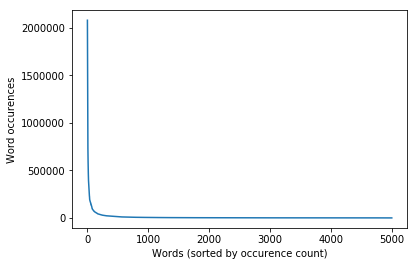

In [8]:
plt.plot(range(0, 5000), [cnts[k] for k in s])
plt.xlabel("Words (sorted by occurence count)")
plt.ylabel("Word occurences")
plt.show()

As expected, we are faced with a [Pareto distribution](https://en.wikipedia.org/wiki/Zipf%27s_law).

## WordCloud

We will now generate a word cloud from these word occurences to visualize the frequencies in a different way.

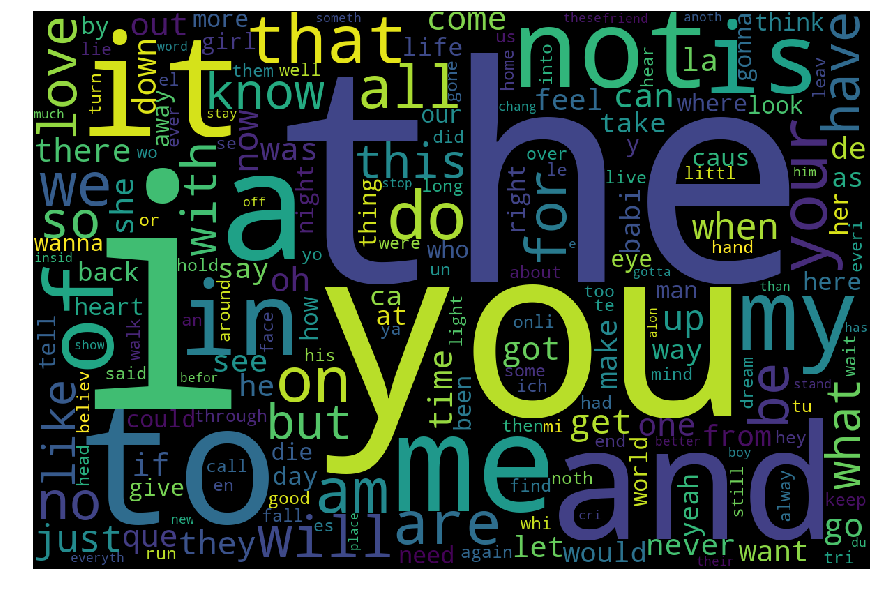

In [9]:
try:
    import wordcloud

    wc = wordcloud.WordCloud(width=1200, height=800)
    wc.generate_from_frequencies(cnts)
    
    plt.figure(figsize=[15,15])
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
except ImportError:
    print("wordcloud package not installed, use `pip install wordcloud`")